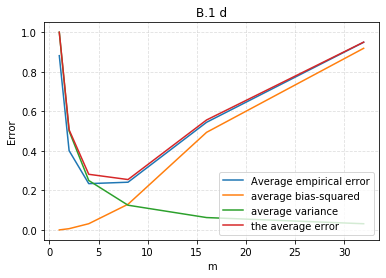

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 14 22:28:26 2020
CSE 546 HW 1 B1
@author: apple
"""

import numpy as np
#import math 
import matplotlib.pyplot as plt
%matplotlib inline
n = 256
sigma = 1

df = np.ones((n,15))
df2 = np.ones((6,5))
##x_i
df[:,0] = np.arange(1,n+1)/float(n)
##f(x_i)
df[:,1] = 4* np.sin(np.pi * df[:,0]) * np.cos(6 * np.pi * df[:,0]**2)
##y_i
df[:,2] = 4* np.sin(np.pi * df[:,0]) * np.cos(6 * np.pi * df[:,0]**2) + np.random.randn(n)
for k in range(0,6):
    m = 2**k
    df2[k,0] = m
    for j in range(1,int(n/m)+1):
        ##hat{f_m(x^i)}
        df[(j-1)*m:j*m,k+3] = np.mean(df[(j-1)*m:j*m,2])
        df[(j-1)*m:j*m,k+9] = np.mean(df[(j-1)*m:j*m,1])
    df2[k,1] = ((df[:,k+3]-df[:,1])**2).sum()/n
    df2[k,2] = ((df[:,k+9]-df[:,1])**2).sum()/n
    df2[k,3] = sigma**2/m
    df2[k,4] = df2[k,2] + df2[k,3]


# Create the vectors X and Y
x_axix = df2[:,0]
#y1= df2[:,1]
# Create the plot 
plt.plot(x_axix,df2[:,1],label='Average empirical error') # Add a title
plt.plot(x_axix,df2[:,2],label='average bias-squared')
plt.plot(x_axix,df2[:,3],label='average variance')
plt.plot(x_axix,df2[:,4],label='the average error')
plt.title('B.1 d')
# Add X and y Label 
plt.xlabel('m') 
plt.ylabel('Error')
# Add a grid 
plt.grid(alpha=.4,linestyle='--') 
# Add a Legend
plt.legend()
# Show the plot
plt.show()

In [5]:
"""
Created on Thu Apr 18 13:10:52 2020
CSE 546 HW 1 b2
@author: Leah
"""
import numpy as np
from mnist import MNIST 
import matplotlib.pyplot as plt
from sklearn import model_selection
import scipy 

img_h = img_w = 28                                                             # MNIST images are 28x28
img_size_flat = img_h * img_w                                                  # 28x28=784, the total number of pixels
n_classes = 10                                                                 # Number of classes, one class per digit

def load_dataset():
    mndata = MNIST('./data/')
    X_train, labels_train = map(np.array, mndata.load_training()) 
    X_test, labels_test = map(np.array, mndata.load_testing()) 
    X_train = X_train/255.0
    X_test = X_test/255.0
                      
    return X_train, labels_train, X_test, labels_test

def trans_coef(p, d):
    mu, sigma = 0, 0.1 # mean and standard deviation
    G = np.random.normal(mu, sigma, (p,d))   
    b = np.random.uniform(0,2 * np.pi,p)
    return G, b
    
def transform(G,b,X,p=1000):
    n, d = X.shape
    h = np.cos(G.dot(X.T) + np.repeat(b,n).reshape((p,n))).T
    return h

def train(h,Y,lamda,p):
    W_hat = scipy.linalg.solve(
            a = h.T.dot(h)+ lamda * np.eye(p),
            b = h.T.dot(Y)
            )
    return W_hat


def predict(W, h):
    X_ = h.dot(W)
    pre_ = X_.argmax(axis=1)
    return pre_



#-----------------------------------------------------------------
#  Main
#-----------------------------------------------------------------
def main():
    n = 10
    gap = 10
    error_table = np.zeros((n-1,3))                     #record the two errors
    
    XX_train, labelss_train, XX_test, labelss_test = load_dataset()                    #LOAD data
    
    #Redistribution data 80/20
    X_ = np.r_[XX_train,XX_test]
    labels_ = np.r_[labelss_train,labelss_test]
    rand_schedule = np.random.permutation(range(len(X_))).tolist()
    slice_list = [0, int(len(X_)/5), int(len(X_)/5*2), int(len(X_)/5*3), int(len(X_)/5*4), len(X_)]
    sliced_schedule = [rand_schedule[slice_list[i]: slice_list[i + 1]] for i in range(len(slice_list) - 1)]
    
    loo = model_selection.LeaveOneOut()  
    
        
    for p in range(1,n*gap,gap):
        itrial = 0
        errorTrains = np.zeros((5, 1))
        errorVal = np.zeros((5, 1))
        print(p)
        for train_index, test_index in loo.split(sliced_schedule): 
            #print (train_index, test_index)
            X_train = np.vstack((X_[sliced_schedule[i]] for i in range(0,len(train_index))))
            X_test = X_[sliced_schedule[test_index[0]]]
            
            labels_train = np.vstack((labels_[sliced_schedule[i]] for i in range(0,len(train_index)))).reshape(int(len(X_)*0.8),)
            labels_test = labels_[sliced_schedule[test_index[0]]]
            
            #X_train, X_test, labels_train, labels_test = train_test_split(X_, labels_, test_size=0.2)
            ## transform labels_train(n-by-1) into n-by-k
            Y_train = np.zeros((len(labels_train),n_classes))
            
            for i in range(0,len(Y_train)):
                Y_train[i,labels_train[i]] = 1
                
            G, b =  trans_coef(p, X_train.shape[1])
            #get w_hat
            X_train = transform(G,b,X_train, p=p)
            X_test = transform(G,b,X_test,p=p)
            
            W_hat = train(X_train,Y_train,lamda = 0.0001,p=p)
            #print(W_hat.shape[0],W_hat.shape[1])
            #predict
            Train_pre = predict(W_hat, X_train)
            Test_pre = predict(W_hat, X_test)
            
            errorTrains[itrial, :] = sum(Train_pre != labels_train)/len(labels_train)
            errorVal[itrial, :] = sum(Test_pre != labels_test)/len(labels_test)
            itrial = itrial + 1
            
        ##training, test error
        error_table[int(p/gap-1),0] = p
        error_table[int(p/gap-1),1] = errorTrains.mean()
        error_table[int(p/gap-1),2] = errorVal.mean()
    
    import pandas as pd 
    error_table = pd.read_excel("1.xlsx")
    error_table = error_table[error_table["a"]>0]
    
    plt.figure(figsize=(10,10))
    plt.plot(error_table[:,0], error_table[:,1], 'r-o')
    plt.plot(error_table[:,0], error_table[:,2],'b-o')
    plt.legend(['Training Error', 'Testing Error'], loc='best')
    plt.title('Learning Curve')
    plt.xlabel('p')
    plt.ylabel('Error')
    
    return error_table

def find_p_hat():
    error_table = main()
    p_hat = int(error_table[error_table[:,2].argmin(axis = 0),0])
    XX_train, labelss_train, XX_test, labelss_test = load_dataset() 
    Y_train = np.zeros((len(labelss_train),n_classes))

    for i in range(0,len(Y_train)):
        Y_train[i,labelss_train[i]] = 1
        
    G, b =  trans_coef(p_hat, XX_train.shape[1])
    
    #get w_hat
    X_train = transform(G,b,XX_train, p=p_hat)
    X_test = transform(G,b,XX_test,p=p_hat)
    
    W_hat = train(X_train,Y_train,lamda = 0.0001,p=p_hat)

    #predict
    Test_pre = predict(W_hat, X_test)
    
    test_error= sum(Test_pre != labelss_test)/len(labelss_test)
    
    # apply Hoeffding’s inequality
    delta = 0.05
    m = len(XX_test)
    ci = np.sqrt(np.log10(2/delta) / (2*m))

    low_bound = test_error - ci
    up_bound = test_error + ci
    
    # result
    print("p_hat: " + str(p_hat))
    print()
    print("Test Error: " + str(test_error))
    print()
    print("Confidence Interval: " + str(low_bound) + "<= mean error <= " + str(up_bound))
    print()
    
find_p_hat()

p_hat: 5801

Test Error: 0.0266

Confidence Interval: 0.017649972091306188<= mean error <= 0.03555002790869381

